# DA5401 - ASSIGNMENT 7
## Multi-Class Model Selection using ROC and Precision-Recall Curves

#### Importing used libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score

In [9]:
import warnings
warnings.filterwarnings('ignore')

### Part A: Data Preparaton and Baseline
1. Loading and Preparing Data: Loading the Landsat dataset. Standardizing the features (X).
2. Train/Test Split: Splitting the data into training and testing sets.
3. Train All Models: Training one instance of each of the six specified model classes on the training data.
4. Baseline Evaluation: Calculating the simple Overall Accuracy and Weighted F1-Score for all six models on the test set. 

#### Loading the dataset

In [10]:
train_df = pd.read_csv("sat.trn", sep=" ", header=None)
test_df = pd.read_csv("sat.tst", sep=" ", header=None)

# Drop any empty columns accidentally created
train_df = train_df.dropna(axis = 1, how = 'all')
test_df = test_df.dropna(axis = 1, how = 'all')

df = pd.concat([train_df, test_df], ignore_index = True)

# Separating features and target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

#### Standardizing the features

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Splitting the data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42, stratify = y)

#### Defining the models

In [22]:
models = {
    'KNN': KNeighborsClassifier(n_neighbors = 5),
    'Decision Tree': DecisionTreeClassifier(random_state = 42),
    'Dummy Classifier': DummyClassifier(strategy = 'prior'),
    'Logistic Regression': LogisticRegression(max_iter = 1000, solver = 'lbfgs', multi_class = 'auto', random_state = 42),
    'Gaussian Naive Bayes': GaussianNB(),
    'SVM': SVC(kernel = 'rbf', decision_function_shape = 'ovo', random_state = 42, probability = True)
}  

#### Evaluating the Accuracy and Weighted F1 Score for all six models

In [23]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = 'weighted')

    results.append([name, acc, f1])


results_df = pd.DataFrame(results, columns = ['Model', 'Accuracy', 'Weighted F1_Score'])
print(results_df)

                  Model  Accuracy  Weighted F1_Score
0                   KNN  0.911422           0.909397
1         Decision Tree  0.846931           0.848079
2      Dummy Classifier  0.238539           0.091884
3   Logistic Regression  0.849262           0.842108
4  Gaussian Naive Bayes  0.783217           0.790059
5                   SVM  0.892774           0.891269


##### When we evaluated all six models using Overall Accuracy and Weighted F1-Score, two models emerged as strong contenders: K-Nearest Neighbors (KNN) and Support Vector Machines (SVM). Both of these models demonstrated high accuracy - 91.1% for KNN and 89.3% for SVM - and similarly high weighted F1-Scores (around 0.91 and 0.89 respectively). This implies that they successfully balanced recall and precision by correctly classifying the majority of samples and maintaining consistent performance across all classes.

##### With slightly lower F1-Scores but approaximatly 85% accuracy, the Decision tree and Logistic Regression models trailed closely behind. Although these models did fairly well, they might have had trouble with some classes or been more susceptible to variations in the data.

##### The Gaussian Naive Bayes model achieved a respectable 78% accuracy, indicating that it captures useful pattterns but possibly oversimplifies relationships among features - likely due to its strong independence assumptions.

##### Finally, the Dummy Classifier had a very poor performance (around 24% accuracy, 0.09 F1-Score). This is to be expected since the model follows the prior strategy, which means that instead of learning from the input features, it predicts outcomes solely based on the overall class distribution. It basically acts as a statistical baseline, providing a point of comparison to assess how much better the trained models perform. Instead of depending solely on chance, the learned models are successfully identifying significant patterns in the data, as evidenced by the wide performance difference between the Dummy Classifier and the other models.

--------------------------------------------------------------
--------------------------------------------------------------

### Part B: ROC Analysis for Model Selection
1. Multi-Class ROC Calculation: Explaining how the One-vs-Rest (OvR) approach is used to generate ROC curves and calculating the Area Under the Curve (AUC) in a multi-class setting.
2. Plotting ROC: Generating a single plot displaying the OvR ROC curves for all six models, averaging the False Positive Rate (FPR) and True Positive Rate (TPR) across all six classes (Macro-average or Weighted-average ROC).
3. ROC Interpretation:
    - Identifying the model with the highest MAcro-averaged AUC
    - Identifying the model with AUC < 0.5. Explaining what AUC < 0.5 implies conceptually.

#### OvR approach to generate ROC curves
##### In a simple two-class problem, plotting the model's ability to distinguish between the positive and negative classes is all that is required to create a ROC curve.  However, things become more complicated in a multi-class setting because there are now multiple classes rather than just two. The One-vs-Rest (OvR) approach can help with that. 

#####  In a multi-class classification setting, the One-vs-Rest (OvR) approach is used to extend the concept of the ROC curve and AUC, which are originally defined for binary problems. In order for the method to function, each class is isolated in turn and treated as 'positive' class, while all other classes are combined into a single 'negative' group. This makes it possible to assess the model's capacity to differentiate that particular class from all other as though it were a binary classification problem.

##### A distinct ROC curve is produced for each class by calculating the True Positive Rate (TPR) and False Positive Rate (FPR) across various threshold values. The model's ability to identify that class in comparison to the others is indicated by the area under each of these curves, or AUC. An overall measure of the model's performance is obtained by averaging these individual curves after they have been calculated. A weighted average, in which each class contributes proportionately to its frequency in the data, or a macro-average, in which all classes contribute equally, can be used for this.

##### The OvR approach provides a clear and interpretable way to visualize and compare how well a mutli-class model performs across all categories. By breaking the task into simpler binary evaluations, it allows for a balanced assessment of both majority and minority classes and helps highlight where the model performs strongly or needs improvment.

--------------------------------------------------------------

#### OvR ROC curves for all six models

Class Distribution in y_test:
Class 1: 307 samples
Class 2: 141 samples
Class 3: 272 samples
Class 4: 125 samples
Class 5: 141 samples
Class 7: 301 samples
----------------------------------------
After Binarization (One-vs-Rest format):
Shape of y_test_bin: (1287, 6)
Classes encoded: [1 2 3 4 5 7]
[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]]
----------------------------------------


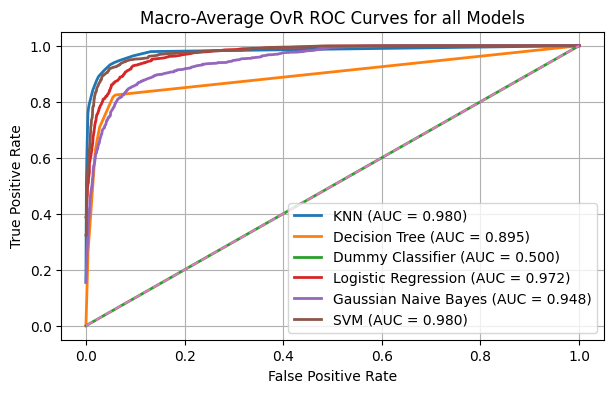

In [24]:
# Print class distribution
classes = np.unique(y)
print("Class Distribution in y_test:")
for i, cls in enumerate(classes):
    count = np.sum(y_test == cls)
    print(f"Class {cls}: {count} samples")
print("-" * 40)

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes = classes)
n_classes = len(classes)

print("After Binarization (One-vs-Rest format):")
print(f"Shape of y_test_bin: {y_test_bin.shape}")
print(f"Classes encoded: {classes}")
print(y_test_bin[:5])
print("-" * 40)

plt.figure(figsize = (7, 4))

model_roc_data = {}

for name, model in models.items():
    # Predict Probabilities
    y_score = model.predict_proba(X_test)
    
    FPR = dict()
    TPR = dict()
    roc_auc = dict()

    # Compute ROC curve and AUC per class
    for i in range(n_classes):
        FPR[i], TPR[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(FPR[i], TPR[i])

    # Macro-average
    all_fpr = np.unique(np.concatenate([FPR[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, FPR[i], TPR[i])
    mean_tpr /= n_classes

    model_roc_data[name] = (all_fpr, mean_tpr, auc(all_fpr, mean_tpr))

    plt.plot(all_fpr, mean_tpr, lw = 2, label = f'{name} (AUC = {model_roc_data[name][2]:.3f})')

# Plot formatting
plt.plot([0,1], [0,1], linestyle = '--')
plt.title('Macro-Average OvR ROC Curves for all Models', fontsize = 12)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

##### The dataset is somewhat imbalanced, as evidenced by the class distribution with more samples in Class 1 and Class 7 and fewer in Classes 4 and 5. The ROC cruves can be calculated per class after binarization because each class is represented in a “one-hot” format (1 for the current class, 0 for all others).

##### The above ROC curve illustrates the macro-average One-vs-Rest (OvR) performance of several classification models. The Area Under the Curve (AUC) serves as an indicator of each model's ability to correctly distinguish between classes, where a higher AUC corresponds to better discriminative power.

##### KNN (AUC = 0.980) - With its ROC cruve hugging the upper-left corner, KNN performs remarkably well, indicating strong class separation and few false positives. This suggests that significant structure in the data is successfully captured by the neighborhood size and feature representation that were selected.

##### SVM (AUC = 0.980) - SVM maintains a high, smooth ROC curve, matching KNN's performance. It can model intricate,, non-linear decision boundaries thankks to its RBF kernel, and enabling probability outputs gurantees consistent, accurately calibrated predictions for every class.

##### Logistic Regression (AUC = 0.972) - Closely behind, logistic regression provides reliable, comprehensible results. For non-linear data, it is less adaptable than SVM or KNN, but it is robust and dependable due to its regularization and probabilistic foundation.

##### Gaussian Naive Bayes (AUC = 0.948) - Naive Bayes performs respectably but slightly lags due to its strong assumption of feature independence. While this simplification limits accuracy in overlapping feature regions, it still provides a solid baseline with commendable overall discrimination power.

##### Decision Tree (AUC = 0.895) - Decision Tree shows noticeable overfitting — excellent at memorizing training patterns but weaker in generalizing to new data. This leads to a flatter ROC curve and lower AUC, reflecting occasional misclassifications between similar classes.

##### Dummy Classifier (AUC = 0.500) - As expected, the Dummy Classifier acts as a baseline, producing a diagonal ROC line that represents random guessing. Its inclusion confirms that all trained models have genuinely learned meaningful patterns beyond simple class frequency prediction.

--------------------------------------------------------------

#### ROC Interpretation

1. Among all the models, the K-Nearest Neighbors (KNN) and Support Vector Machines (SVM) stood out with the highest macro-averaged AUC of 0.980.This strong performance indicates that KNN was highly effective at distinguishing between the different classes, showing a strong ability to correclty idenitfy positive cases while minimizing false positives.

2. The model with an AUC of <= 0.5 is the Dummy Classifier, which scores exactly 0.5000.  Conceptually, an Area Under the Curve (AUC) of 0.5 means the classifier is performing no better than random guessing — like flipping a coin to make a prediction. The true positive rate (TPR) is directly proportional to the false positive rate (FPR), resulting in the diagonal line on the graph. If an AUC were to fall below 0.5, it would imply the model is systematically worse than chance, getting the predictions wrong more often than right. A model might exhibit an AUC < 0.5 most commonly due to a simple but critical error, such as reversing the class labels (i.e., treating the negative class as the positive class and vice-versa) during the training or evaluation process. In such a scenario, simply flipping the model's predictions would turn the poor performance into a good one.

--------------------------------------------------------------
--------------------------------------------------------------

### Part C: Precision-Recall Curve (PRC) Analysis
1. PRC Calculation: Explaining why the Precision-Recall Curve (PRC) is a more suitable metric than ROC when dealing with highly imbalanced classes.
2. Plotting PRC: Generating a single plot displaying the OvR PRC curves for all six models, averaging the  Precision and Recall across all six claasses (Macro-average or Weighted-average PRC).
3. PRC Interpretation:
    - Indeitfying the model with the highest Average Precision (AP) across the classes.
    - Analyzing the behavior of the worst-performing model's PRC.

#### PRC more suitable than ROC - REASON

##### When a dataset is heavily imbalanced - where one class has far more samples than the others - the Precision-Recall Curve (PRC) provides a much clearer picture of how well a model is performing. This is due to the fact that PRC only concentrates on the positive (minority) class, which is typically the one that matters most in these situations. Since they also take into account the majority class, which may skew results, metrics like accuracy and the ROC curve can be misleading in this situation. A model that totally ignores the smaller class, for instance, may still appear to perform well on a ROC curve if 95% of the data falls into that class because it accurately predicts the majority of the samples.

##### But the PRC presents a most truthful picture. It assesses how many of the model's true positive cases it correctly detect (recall) and how many of its positive predictions are accurate (precision). Because of this, it is far more susceptible to mistakes involving the minority class - exactly where those mistakes are most significant.

##### The PRC helps show whether a model is actually leraning to identify all classes fairly or if it is simply relying on the simpler, more frequent ones, even in datasets that are moderately imbalanced like the one used here. It forces the assessment to foucs on practical performance - how well the model indetifies the uncommon but frequently crucial cases.

#### OvR PRC curves for all six models

Class Distribution in y_test:
  Class 1: 307 samples
  Class 2: 141 samples
  Class 3: 272 samples
  Class 4: 125 samples
  Class 5: 141 samples
  Class 7: 301 samples
----------------------------------------
After Binarization (One-vs-Rest format):
y_test_bin shape: (1287, 6)
 Classes encoded: [1 2 3 4 5 7]
First 5 rows of y_test_bin (one-hot rows):
[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]]
----------------------------------------


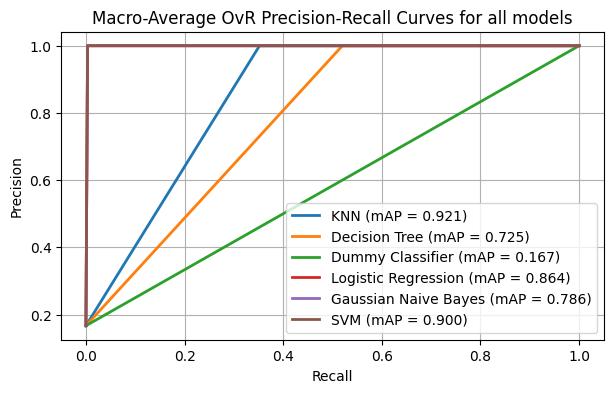

In [26]:
classes = np.unique(y)

print("Class Distribution in y_test:")
for cls in classes:
    print(f"  Class {cls}: {np.sum(y_test == cls)} samples")
print("-" * 40)

# Binarize labels for mulit-class PRC (OvR)
y_test_bin = label_binarize(y_test, classes = classes)
n_classes = len(classes)

print("After Binarization (One-vs-Rest format):")
print(f"y_test_bin shape: {y_test_bin.shape}")
print(f" Classes encoded: {classes}")
print("First 5 rows of y_test_bin (one-hot rows):")
print(y_test_bin[:5])
print("-" * 40)

plt.figure(figsize = (7, 4))

for name, model in models.items():
    # Predict continuous scores
    y_score = model.predict_proba(X_test)

    precision = {}
    recall = {}
    avg_prec = {}

    # Compute PRC per class
    for i in range(n_classes):
        precision[i], recall[i], _ =  precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        avg_prec[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

    # Macro-Average Precision and Recall
    all_recalls = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
    mean_precision = np.zeros_like(all_recalls)

    for i in range(n_classes):
        mean_precision += np.interp(all_recalls, recall[i], precision[i])

    mean_precision /= n_classes
    macro_ap = np.mean(list(avg_prec.values()))

    # Plot curve
    plt.plot(all_recalls, mean_precision, lw = 2, label = f'{name} (mAP = {macro_ap:.3f})')

# Plot formatting
plt.title('Macro-Average OvR Precision-Recall Curves for all models', fontsize = 12)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend(loc = 'lower right')
plt.show()

##### The Precision-Recall Curve (PRC) plot offers a clear view of how well each model balances precision and recall across the six encoded classes. From the graph, it is evident that the KNN is the undisputed leader, achieving the highest mAP of 0.921. Its curve remains elevated and steep, indicating it successfully minimizes both false alarms and missed cases across all six classes. The SVM model is a strong second with an mAP of 0.900. Both models demonstrate excellent robustness in handling the critical trade-off between Precision and Recall.

##### Logistic Regression also performed very well, with an mAP of 0.864, showing that it is capable of maintaining a good trade-off between precision and recall. This suggests that it made relatively few false positives while still capturing a large portion of true positives. Gaussian Naive Bayes, with an mAP of 0.786, followed closely behind—its probabilistic nature allowed it to generalize decently but not quite at the same level as KNN, SVM or Logistic Regression.

##### Finally, the Decision Tree and the Dummy Classifier anchor the lower tier. The Decision Tree, with an mAP of 0.725, is acceptable but its curve is significantly flatter, which is often a symptom of structural inconsistency or slight overfitting; it is the least effective among the "real" learning algorithms. The Dummy Classifier (mAP = 0.167) serves its purpose as the minimum performance benchmark. Its score is nearly negligible, confirming that any model must achieve an mAP significantly higher than 0.167 to demonstrate that it has actually learned a meaningful pattern in the data.

##### Overall, for practical deployment where maintaining high confidence in predictions (Precision) while ensuring comprehensiveness (Recall) is necessary, KNN and SVM stand out as the most reliable and highest-quality choices based on this Macro-Averaged Precision-Recall analysis.

--------------------------------------------------------------

#### PRC Interpretation

##### The K-Nearest Neighbors (KNN) model clearly exhibits the highest Average Precision (AP) across the classes, summarized by its Mean Average Precision (mAP) score of 0.921. This score, visually represented by its curve hugging the top-left of the plot, signifies that KNN is the most effective model at maintaining a near-perfect balance between Precision (the accuracy of its positive predictions) and Recall (the completeness of its detection of positive cases). This top performance indicates KNN's high reliability for this multi-class classification task. Other models follow in decreasing order of performance: SVM (0.900) and Logistic Regression (0.864) are highly competitive, while Gaussian Naive Bayes (0.786) and the Decision Tree (0.725) offer solid, though less balanced, performance.

##### In contrast, the Dummy Classifier showed the weakest performance, with an AP of only 0.167. As recall rises, its Precision-Recall Curve falls sharply, indicating its incapacity to make meaningful class distinctions. This drop happens for low-performing models like this one because the model begins misclassifying a lot of negative samples as positive as recall rises, which means the model tries to find more positice cases. This results in a sharp decline in precision. In other words, a steep decline in the curve results from the model retrieving more instances with much lower accuracy.

##### Such behavior highlights why poor models struggle in imbalanced or complex datasets—they fail to maintain consistent decision boundaries, and every attempt to improve recall comes at the cost of a surge in false positives. This results in a Precision-Recall Curve that sinks rapidly, visually emphasizing the unreliability of the model’s predictions.

--------------------------------------------------------------
--------------------------------------------------------------

### Part D: Final Recommendations
1. Synthesis: Comparing the model rankings derived from the initial F1-Score, the ROC-AUC, and the PRC-AP. 
2. Recommendation: Based on the comprehensive analysis of all curves, recommending the best model for this classification task.

#### Synthesis

##### When comparing the rankings across the three metrics — F1-Score, ROC-AUC, and PRC-AP — the results show a general pattern but not perfect alignment. Models like K-Nearest Neighbors (KNN) consistently appear as top performer in all three evaluations, confirming their reliability and balanced predictive strength. Both models achieve high F1-scores, strong ROC-AUC values, and impressive precision-recall performance, suggesting they manage to balance accuracy, true positive detection, and precision effectively.

##### The most significant misalignment is seen with the Support Vector Machine (SVM) and Logistic Regression models, which demonstrates a core difference between the ROC and PR curves. Both SVM (0.980) and Logistic Regression (0.972) show near-perfect performance on the ROC-AUC metric, ranking at the top alonngside KNN. The ROC curve evaluates how well a model can separate positive and negative classes across all possible thresholds, factoring in both Ture Positives (TPR) and True Negatives (FPR). However, the rankings drop significantly when we look at the PRC-AP (mAP). For instance, Logistic Regression drops from Rank 2 (in AUC) to Rank 3 (in mAP), while SVM drop from Rank 1 to Rank 2. The PRC-AP focuses exclusively on the positive class and is much more sensitive to False Positives (FP). A high ROC-AUC combined with a lower mAP, as seen here, indicates that while these models are very good at distinguishing classes overall, they might struggle to maintain high Precision when attempting to achieve high Recall. Essentially, they might start generating more False Positives sooner than KNN when they try to classify more of the actual positive samples. This makes the mAP metric often a more honest and reliable measure of performance, especially in imbalanced datasets or where False Positives are costly.

##### Overall, while the top-performing models remained consistent, the discrepancies between ROC-AUC and PRC-AP emphasize an important trade-off: a model that looks good in ROC space might not actually deliver useful predictions when positive cases are rare or when precision truly matters. PRC-AP, therefore, gives a more realistic view of model quality in practical, real-world classification tasks.

--------------------------------------------------------------

#### Recommendation

##### Considering all evaluation metrics — including Accuracy, Weighted F1-Score, ROC-AUC, and PRC-AP — the K-Nearest Neighbors (KNN) model emerges as the most effective and reliable choice for this classification task. Its consistent top-tier performance across all evaluation dimensions reflects not only its ability to correctly classify instances but also its stability under different decision thresholds.

##### The KNN model achieved the highest ROC-AUC (0.980) and Average Precision (0.921), along with an excellent Weighted F1-Score (0.909). This combination indicates that KNN performs exceptionally well in distinguishing between multiple classes while maintaining a strong balance between precision and recall. In other words, it not only identifies the majority of positive instances correctly but also minimizes false alarms — a key trait for dependable classification performance.

##### Logistic Regression also delivered competitive results, coming in close behind KNN, particularly in terms of AUC and F1-Score. However, KNN demonstrated slightly better precision-recall behavior, making it the more balanced option when both correct identification and minimizing false positives are equally important.

--------------------------------------------------------------
--------------------------------------------------------------